In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Light GBM with HPO

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb

## Load Data and Create Features / Labels

In [3]:
df = pd.read_csv('../../data/raw/training.csv', index_col=0)

X = df.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = df['mobile_money_classification']

X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,-1,2,-1,1,-1,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,-1,2,-1,1,-1,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,-1,4,-1,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,-1,1,1,1,-1,1,4,-7.179645,31.039095


## Setup scoring function and baseline parameters

In [4]:
from pprint import pprint
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss

seed = 2019

np.random.seed(seed)

def zindi_score(y_test, probs):
    """
    Score as we are being scored on LB
    """
    losses = []
    for c in [0,1,2,3]:
        labels = [1 if i == c else 0 for i in y_test]
        loss = log_loss(labels, probs[:, c])
        losses.append(loss)
    return sum(losses)


n_classes = y.nunique()

# Params that won't be changed
static_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'metric': ['multiclass'],
    'num_class': n_classes,
    'verbose': 0,
    'seed': 2019
}

## Define Training Method and Fixed Params

In [5]:
import skopt
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=5)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [41]:
SPACE = [skopt.space.Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
         skopt.space.Integer(1, 30, name='max_depth'),
         skopt.space.Integer(2, 100, name='num_leaves'),
         skopt.space.Integer(10, 1000, name='min_data_in_leaf'),
         skopt.space.Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
         skopt.space.Real(0.1, 1.0, name='subsample', prior='uniform'),
         ]

CAT_VARS = ['Q2','Q3','Q4','Q5','Q6','Q7','Q8_1',
            'Q8_2','Q8_3','Q8_4','Q8_5','Q8_6',
            'Q8_7','Q8_8','Q8_9','Q8_10','Q8_11',
            'Q9','Q10','Q11','Q12','Q13','Q14',
            'Q15','Q16','Q17','Q18','Q19']
CONT_VARS = ['Q1']
LOC_VARS = ['Latitude','Longitude']

NUM_BOOST_ROUND=100
EARLY_STOPPING_ROUNDS=10

def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=1234)

def train_evaluate(X, y, params, return_model=False):
    X_train, X_valid, y_train, y_valid = split_data(X, y)

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    model = lgb.train(params, train_data,
                      num_boost_round=NUM_BOOST_ROUND,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      verbose_eval=False,
                      valid_sets=valid_data, 
                      valid_names=['valid'])
    
    if return_model:
        return model
    else:
        return model.best_score['valid']['multi_logloss']

@use_named_args(SPACE)
def objective(**params):
    new_params = {**static_params, **params}
    return 1.0 * train_evaluate(X, y, new_params)

def to_named_params(params, space=SPACE):
    return({dimension.name: param for dimension, param in zip(SPACE, params)})


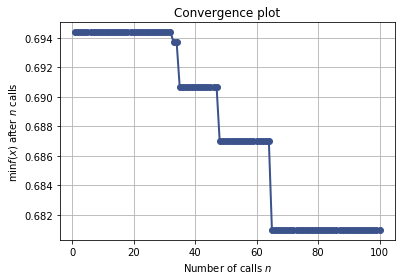

In [21]:
results = skopt.forest_minimize(objective, space, callback=[plot_callback], n_calls=100, n_random_starts=10)

In [31]:
best_params = to_named_params(results.x)
print("Best Score: ",results.func_vals[-1])
print('Best Params: ')
pprint(best_params)

Best Score:  0.6964160119302739
Best Params: 
{'feature_fraction': 0.949117079748278,
 'learning_rate': 0.46944312992849224,
 'max_depth': 8,
 'min_data_in_leaf': 19,
 'num_leaves': 53,
 'subsample': 0.2637814876895612}


## Inspect Predictions

### Create features from test data

In [44]:
X_test_proc = preprocessing_pipeline.fit_transform(X_test)
X_test_proc = pd.DataFrame(X_test_proc, columns=features)
X_test_proc.head()

,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q2,Q3,Q4,...,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,mm_agents_5km
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,1.0,4.0,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,2.0,4.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,...,-1.0,2.0,-1.0,1.0,6.0,5.0,-1.0,1.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,...,4.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,5.0,5.0,1267.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,...,-1.0,1.0,2.0,1.0,2.0,4.0,-1.0,2.0,4.0,290.0


### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

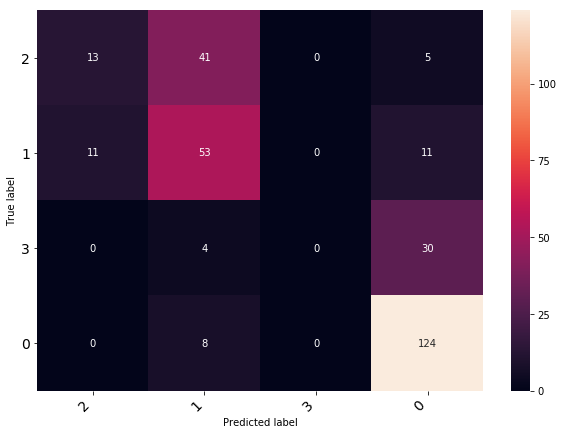

In [48]:
test_preds = best_model.predict(X_test_proc)

class_names = y_test.unique()

cm = confusion_matrix(y_test, test_preds)

plot = print_confusion_matrix(cm, class_names)

## Retrain Model using best parameters

In [46]:
X_train, X_valid, y_train, y_valid = split_data(X, y)

model = train_evaluate(X, y, {**static_params, **best_params}, return_model=True)

val_probs = model.predict(X_valid)

print('Zindi Score = ',zindi_score(y_valid, val_probs))

Zindi Score =  1.9920342619047133


**Not great....**

## Create Submission

In [43]:
from src.utils import make_sub

In [44]:
X_test = pd.read_csv('../../data/raw/test.csv', index_col=0)

test_probs = model.predict(X_test)

sub_df = make_sub(test_probs)

sub_df.head()

,no_financial_services,other_only,mm_only,mm_plus
2352,0.282249,0.282476,0.340557,0.658910
8208,0.282249,0.282476,0.323580,0.665994
2785,0.282249,0.282476,0.340557,0.658910
2967,0.408004,0.562884,0.286198,0.292235
1697,0.282249,0.282476,0.340557,0.658910


In [45]:
sub_df.to_csv('../../data/submissions/lgbm_tuned.csv')

### Zindi Results

Got a score of 1.97908482439022 on Zindi. 